#Final Project

Context
You are a conservation biologist in charge of managing habitats for a protected
reserve. Your reserve includes several distinct patches of intact forest that harbor
populations of the endangered Warbling Babbler. You are worried about the longterm
fate of these populations if the habitats remain disconnected with limited
movement of individuals between them (i.e., limited migration between the
populations), so youʼd like to use funds from your budget to establish habitat
corridors that will allow individuals to move between the patches. However, you also
know that the populations have some phenotypic differences (like color) and you are
wondering how the frequencies of the phenotypes, and the overall population sizes,
will change in the populations once they are connected.


In [5]:
# Import necessary modules
import matplotlib.pyplot as plt
import random
import numpy as np

Your framework will include three types of classes: an Individual class, a Population class, and a Landscape class. Individuals exist in populations, and populations exist in a landscape. In each time step of your simulation, individuals can stay in the population where they started, or move to a
new population. The probabilities that individuals stay or leave are stored in a table called a dispersal matrix (more detail below).

In [6]:
class Individual:
    """Class to hold information on indiviuals."""
    def __init__(self, id, phenotype):
        """The constructor for the individual class, with id and phenotype as attributes."""
        self.id = id
        self.phenotype = phenotype

Population constructors should create a new list for individuals in that population,
and Populations should have methods to add and remove individuals, as well as to
calculate and print the frequency of phenotypes among individuals.

In [7]:
class Population:
    """Class to hold information on populations that is composed of individuals."""
    def __init__(self, id, popSize, phenotype): 
        """"The constructor for the population class."""
        self.id = id
        self.individuals = [] #create a list of individuals
        for i in range(popSize):
            self.individuals.append(Individual("%s-%d" % (id, i+1), phenotype)) #loop through the population (based on popSize) and add individuals to the individuals list, with       numbering for the id value starting at 1 (hence the i+1)

    def addIndividual(self, individual):
        """A function that adds individuals to a list."""
        self.individuals.append(individual)
    
    def removeIndividual(self, individual):
        """A function that removes individuals from a list."""
        try:
            self.individuals.remove(individual)
        except ValueError: #this fixes continuous errors that were occurring due to the remove function not working properly...it makes the function work despite errors
            pass
    
    def calculateFreq(self, phenotype):
        """This function calculates the frequency of phenotypes found in a population."""
        freq = 0 #set the original frequency to zero to then calculate it later
        for ind in self.individuals: #loop through the list of individuals
             if ind.phenotype == phenotype: #if the phenotype in the list of individuals is equal to itself, then increase frequency by 1
                 freq = freq + 1
        return freq #save the value of the frequency for later use
    
    def printFreq(self, phenotype): #useful in testing of the code
        """Function to print out the phenotype and its frequency."""
        print("The %s phenotype frequency is %d" % (phenotype, self.calculateFreq(phenotype))) #this function calls the previous function of calculateFreq

In [5]:
testPopulation = Population("popA", 12, "purple")
for ind in testPopulation.individuals:
    print(ind.phenotype) 
testPopulation.printFreq("purple")

purple
purple
purple
purple
purple
purple
purple
purple
purple
purple
purple
purple
The purple phenotype frequency is 12


Landscape constructors should create a new list for the populations in that landscape, and Landscapes should have a method that uses the probabilities in the dispersal matrix to determine if an individual moves or stays each time step. Either the Population or Landscape constructors should set the starting population sizes. The total number of individuals across all populations should stay constant, but individual populations may change size.

In [33]:
class Landscape:
    """Class to hold information on landscapes, which are composed of different populations, which in turn have different individuals."""
    
    def __init__(self, popSize=10, phenotypes=None, dispersalMatrix=None, simulationSteps=1): 
        """"The constructor for the Landscape class, taking population size, the different phenotypes, a dispersal matrix, and number of time steps as arguments."""
        self.dispersalMatrix = dispersalMatrix
        self.simulationSteps = simulationSteps
        self.phenotypes = phenotypes
        self.popSizeRecords = [[popSize] * len(phenotypes)] #records popSize for step zero and will be used later for future records of popSize per simulation step
        self.phenoFreqRecords = [[]] #list in a list to keep a record of changes in phenotype frequencies throughout simulation steps. [[[10,0,0],[0,10,0],[0,0,10]],[...]]
        self.populations = [] #creates a list of populations
        for i in range(len(phenotypes)): #iterate through the populations (initially determined by the number of phenotypes since one phenotype per population)
            self.populations.append(Population('pop%s' % chr(65 + i), popSize, phenotypes[i])) #append each population to the list of populations, numbering based on alphabet, A is chr 65
            popPhenoFreq = [0] * len(phenotypes) #creates a list of phenotypic frequencies, one per each phenotype/population provided
            popPhenoFreq[i] = popSize #since all individuals of one population have one specific phenotype, for each population set one of the indexes equal to the population size, i.e. 10 individuals will mean 10 blue in blue population, 10 green in green population. This is only for the first stage though, hence why is init.
            self.phenoFreqRecords[0].append(popPhenoFreq) #appends the above info into the attribute so the value is stored for use later        
    
    def migratePop(self): #function to move from one population to another
        """Function to move individuals from one population to another, with the probability that the individual moves based on the inputted dispersal matrix."""
        migrationRecords = {} #create a dictionary to retain info about the migration
        for i in range(len(self.populations)): #loop through the list of populations
            popSize = len(self.populations[i].individuals)  #the population size is equal to the length of the list
            probWeights = self.dispersalMatrix[i] #this sets the probability whether an individual moves and need to put a dispersal matrix as an input
            popIndexList = list(range(0, len(self.populations))) #make a list recording the indexes for the population from zero to the number of populations
            migrationMap = random.choices(popIndexList, weights=probWeights, k=popSize) #this randomly selects the destination population from the popIndex list, using the weights for the seleciton from the dispersal matrix, and does it for each individual, determined by popsize 
            #e.g. output for migrationMap => [0,1,0,0,2,0,0,2,1,0] showing zero individuals from pop A stayed in pop A, with 1 individual moving from popA to popB
            sourcePopId = self.populations[i].id #this makes a list for the source population
            for indIndex, destPopIndex in enumerate(migrationMap): #gets back the indexes and the value for the migrationMap (so the index and the destination population)
                if destPopIndex != i: #if the value of destpop does not equal the population id then...
                    
                    migrant = self.populations[i].individuals[indIndex] #identify the individual as a migrant

                    if sourcePopId in migrationRecords:
                        migrationRecords[sourcePopId].append({'migrant': migrant, 'destPopIndex': destPopIndex, 'sourcePopIndex': i}) #if the source population is in the migration Record dictionary, then append it to the dictionary, otherwise, create a new occurance in the dictionary
                    else:
                        migrationRecords[sourcePopId] = [{'migrant': migrant, 'destPopIndex': destPopIndex, 'sourcePopIndex': i}]
                
        for pop in migrationRecords: #loop through each of the populations in the dictionary
            for record in migrationRecords[pop]: #for each of the populations, then loop through each of the records, i.e. sourcePopIndex, destPopIndex, migrant
                sourcePopIndex = record['sourcePopIndex']
                destPopIndex = record['destPopIndex']
                migrant = record['migrant']
                self.populations[destPopIndex].addIndividual(migrant) #use the add individual function to add the migrant to the destination population from the original self.populations
                self.populations[sourcePopIndex].removeIndividual(migrant) #use the remove individual function to remove the migrant from the source population from the original self.populations
        self.storePopSize() #this returns this value for later usage
        self.storePhenoFreq()
           
    def storePopSize(self):
        """Store population size per simulation step to facilitate plotting."""
        tempPopSizeRecords = [] #create a temporary list for the records of population size
        for pop in self.populations: #iterate through the populations
            tempPopSizeRecords.append(len(pop.individuals)) #temporarily store population sizes for each population, as long as the number of populations for each simulation step, e.g. popA has 110, pop B has 66, pop C has 90, pop D has 100....then simulation step 2 happens.
        self.popSizeRecords.append(tempPopSizeRecords) #store final population sizes in the landscape attribute for each simulation stage per population    

    def storePhenoFreq(self):
        """Store phenotype frequencies per simulation step to facilitate plotting."""
        tempPhenoFreqRecords = []
        for pop in self.populations:
            for phenoIndex, pheno in enumerate(self.phenotypes): #spit out the indices and the value in phenotypes list
                if phenoIndex < len(tempPhenoFreqRecords): #if the index is less than the length found in the records--so if list is empty--then...
                    tempPhenoFreqRecords[phenoIndex].append(pop.calculateFreq(pheno)) #in the atempPhenoFreqRecords list append the calculation of the value of phenotype per population
                else:
                    tempPhenoFreqRecords.append([pop.calculateFreq(pheno)]) #if there is already a value there then append it to the list 
        self.phenoFreqRecords.append(tempPhenoFreqRecords) #attach the temporary list to the function called by the object
        print(tempPhenoFreqRecords) #####ASK NIJO TO GO OVER THIS BIT WITH MEEEEE!!!!! ####

    def startSimulation(self): #a function to call how many time steps the simulation should be run for
        """Function that will call how many times steps the simulation should be run for."""
        for i in range(self.simulationSteps):
            print('Simulating step %d...' % (i+1))
            self.migratePop() #call this function to initiate the migration
        print('Simulation complete.')
   
    def plotPopSizes(self):
        """Function to plot the summary of populations per simulation stage."""
        xValues = list(range(0, self.simulationSteps + 1)) #Generate the data for the x values, the number of simulation steps
        transPopSizeRecords = np.array(self.popSizeRecords).T.tolist() #transpose the values in order to plot them according to population, and not according to simulation step...i.e. popA: 100, 98, 96, 90 (this is popA size at each stage for 4 stages...before it used to be Sim1: 100, 92, 90 for each of the popoulations)..the tolist sends it to a new list!

        # Setting up the plot
        plt.title("Population Size Changes") 
        plt.ylabel("Population (individuals)")
        plt.xlabel("Simulation Step")

        for popIndex, yValues in enumerate(transPopSizeRecords):
            plt.plot(xValues, yValues, marker="o", label=self.populations[popIndex].id)  #line plot using the xaxis from above and yaxis is value from transposed list above
        
        plt.locator_params(axis="both", integer=True, tight=True) #this creates tick marks on both axes
        plt.margins(0.05)
        plt.legend() #need to have determined the label above for the legend to work
        plt.show()
    
    def plotPhenoFreq(self):
        """Function to plot the total phenotypes per populations per simulation stage."""
        # Generating frequency data
        xValues = list(range(0, self.simulationSteps + 1))
        transPhenoFreqRecords = np.array(self.phenoFreqRecords).T.tolist() #transpose the values in order to plot them according to population, and not according to simulation step...i.e. popA: 100, 98, 96, 90 (this is phenotype number for one phenotype per population at each stage for 4 stages..the tolist sends it to a new list! #with transposing it considers per population, then group by phenotype

        for phenoIndex, pheno in enumerate(self.phenotypes): #set up a separate plot for each phenotype
            plt.title("Phenotype '%s' Frequency Changes" % pheno) #use the phenotype of choice as the plot title
            plt.ylabel("Population (individuals)")
            plt.xlabel("Simulation Step")

            for popIndex, pop in enumerate(transPhenoFreqRecords):
                yValues = pop[phenoIndex] #get the values of each phenotype as the y values
                plt.plot(xValues, yValues, marker="o", label=self.populations[popIndex].id)  #line plot using the xaxis as number of simulation steps, yValues are the total number of a specific phenotype in a population at the end of a simulation

            plt.locator_params(axis="both", integer=True, tight=True) #add tick marks to both axes
            plt.margins(0.05)
            plt.legend()
            plt.show()    

    def plotPhenoSummary(self):
        """Function to plot the distribution of phenotypes per population in the last simulation stage."""
        labels = self.phenotypes
        for pop in self.populations: #plot it per population
            popSummary = []
            # Setting up the plot
            plt.title("Phenotype Distribution for %s" % pop.id) 
            for pheno in self.phenotypes:
                popSummary.append(pop.calculateFreq(pheno)) #calculate the frequency of each phenotype for the last stage

            plt.pie(popSummary, labels=labels, autopct=lambda p : '{:.1f}%({:,.0f})'.format(p,p * sum(popSummary)/100), shadow=True, startangle=140)
            plt.axis('equal')
            plt.show()

    def printLandscapeStatus(self):
        """Function to print last status of Landscape status, useful for testing purposes."""
        print('\nFinal landscape status:')
        for pop in self.populations: #iterate through the populations
            print('Population: %s' % pop.id)
            for ind in pop.individuals:
                print('%s => %s' % (ind.id, ind.phenotype))


Simulating step 1...
[[66, 12, 22], [18, 69, 13], [20, 18, 62]]
Simulating step 2...
[[51, 21, 28], [26, 40, 34], [33, 22, 45]]
Simulating step 3...
[[50, 21, 29], [35, 30, 35], [33, 25, 42]]
Simulating step 4...
[[44, 29, 27], [35, 29, 36], [38, 28, 34]]
Simulating step 5...
[[43, 23, 34], [40, 23, 37], [36, 33, 31]]
Simulating step 6...
[[39, 20, 41], [39, 24, 37], [41, 30, 29]]
Simulating step 7...
[[39, 22, 39], [29, 26, 45], [43, 29, 28]]
Simulating step 8...
[[39, 27, 34], [40, 21, 39], [39, 27, 34]]
Simulating step 9...
[[41, 25, 34], [38, 25, 37], [35, 21, 44]]
Simulating step 10...
[[32, 24, 44], [34, 28, 38], [33, 27, 40]]
Simulation complete.


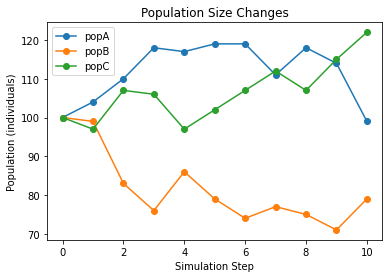

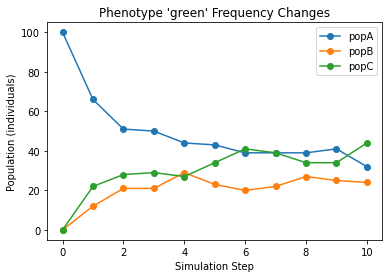

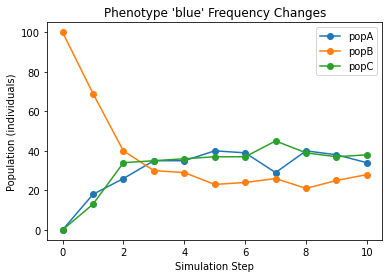

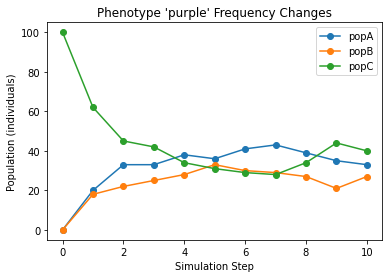

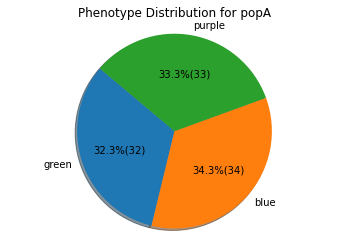

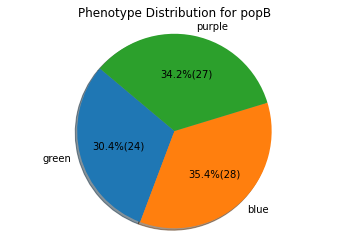

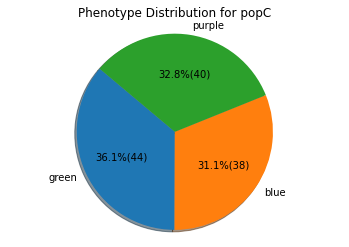

In [34]:
phenotypes = ['green', 'blue', 'purple']
dispersalMatrix = [ #the matrix needs to equal the number of populations, established by the number of phenotypes provided (as colors)
    [0.7, 0.1, 0.2],
    [0.2, 0.6, 0.2],
    [0.2, 0.2, 0.6],
    [0.1, 0.1, 0.8]]
steps = 10 #(this indicates the number of time steps for the simulation)
popSize = 100 

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps) #store the values in this way so easier to change them above rather than when running the simulation
testLandscape.startSimulation()
#call the plotting functions:
testLandscape.plotPopSizes()
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

How do the frequencies of phenotypes change in each population week-by-week as individuals move?

In [ ]:
phenotypes = ['green', 'blue', 'purple', 'red']
dispersalMatrix = [
    [0.6, 0.1, 0.2, 0.1],
    [0.2, 0.6, 0.1, 0.1],
    [0.1, 0.2, 0.6, 0.1],
    [0.1, 0.1, 0.3, 0.5]]
steps = 10
popSize = 100

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPopSizes()
testLandscape.plotPhenoFreq()
testLandscape.plotPopSummary()

What effect does an overall increase in the rate of movement (migration) have?

What happens to both phenotype frequencies and population sizes when movement
probabilities are not symmetric (individuals have a higher probability of
moving from population A to population B, than they do of moving from
population B to population A)?

What effect does changing the starting population sizes have on the trajectory of phenotype frequencies? In other words, what might happen if you connect big habitat patches versus small habitat patches?